In [1]:
import sys
import time

from geopy.geocoders import Nominatim

import pyspark.sql.functions as f
from pyspark import SparkContext
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import lower, col, size, length
from operator import add
from pyspark.ml.feature import Tokenizer, StopWordsRemover, RegexTokenizer

import pandas as pd
import numpy as np

spark = SparkSession\
  .builder \
  .appName("Twitter_app") \
  .getOrCreate()

### Loading Stop Words:

In [2]:
## Reading from the stopword file:
text_file = open("datasets/stop_words_english.txt", "r", encoding="utf-8")
lines = text_file.read()

## Creating the stop word array:
stopWords = lines.split()
# Adding http and https to it:
stopWords.append('http')
stopWords.append('https')
stopWords[-10:]

['whim',
 'whod',
 'whos',
 'widely',
 'words',
 'world',
 'youd',
 'youre',
 'http',
 'https']

### Loading the Data:

In [3]:
#Load the data
data = spark.read.format('json').options(header='true', inferSchema='true') \
  .load('./datasets/NoFilterEnglish2020-02-04.json')

### Exercise 1

##### Words preprocessed:

In [4]:
# Clean text
clean_texts = data.select('*', lower(f.regexp_replace(f.col('text'), r'[^a-zA-Z#@,!\\s]', ' ')).alias('text2'))\
                  .drop('text')\
                  .withColumnRenamed('text2', 'text')

clean_texts.select('text').show(1, False)

+---------------------------------------------------------+
|text                                                     |
+---------------------------------------------------------+
|@theythemsbian thank you for being brave enough to say it|
+---------------------------------------------------------+
only showing top 1 row



#### Tokenize the words:

In [5]:
# Tokenize text
tokenizer = Tokenizer(inputCol='text', outputCol='words_t')
clean_word_tokens = tokenizer.transform(clean_texts)

clean_word_tokens.select('words_t').show(1, False)

+--------------------------------------------------------------------+
|words_t                                                             |
+--------------------------------------------------------------------+
|[@theythemsbian, thank, you, for, being, brave, enough, to, say, it]|
+--------------------------------------------------------------------+
only showing top 1 row



#### Remove useless words:

By useless, we mean the words of size 2 or less.

In [6]:
## Defining the function: (udf: user defined function)
filter_length_udf = f.udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
#clean_word_tokens = clean_word_tokens.withColumn('words', filter_length_udf(col('words_t')))
clean_word_tokens = clean_word_tokens.withColumn('words', col('words_t'))

clean_word_tokens.select('words').show(1, False)

+--------------------------------------------------------------------+
|words                                                               |
+--------------------------------------------------------------------+
|[@theythemsbian, thank, you, for, being, brave, enough, to, say, it]|
+--------------------------------------------------------------------+
only showing top 1 row



#### Creating the view words:

In [7]:
exp_words = clean_word_tokens.withColumn('word', f.explode('words'))\
                             .drop('words')
                 
#Tokenizer
exp_words.select('text', 'word').show(4)

exp_words.createOrReplaceTempView("words")



+--------------------+--------------+
|                text|          word|
+--------------------+--------------+
|@theythemsbian th...|@theythemsbian|
|@theythemsbian th...|         thank|
|@theythemsbian th...|           you|
|@theythemsbian th...|           for|
+--------------------+--------------+
only showing top 4 rows



#### Getting most frequent words in a given period of time using SPARK SQL:

In [8]:
def FreqWords(ts1, ts2, table = "words"):

    sqlDF = spark.sql("SELECT word, count(*) AS word_count " + 
                      "FROM {} ".format(table) + 
                      "WHERE {0}.timestamp_ms BETWEEN {1} AND {2} ".format(table, ts1, ts2)+ 
                      "GROUP BY word " + 
                      "ORDER BY word_count DESC")
    sqlDF.show(10)
    return sqlDF

In [9]:
ts1 = 1580770795658
ts2 = 1580770796665


t1 = time.time()
FreqWords(ts1, ts2, table = "words")
t2 = time.time()

print("time spent computing: {:.4g}".format(t2-t1))

+-----+----------+
| word|word_count|
+-----+----------+
|     |       121|
|   rt|        21|
|  the|        13|
|    i|        10|
|    t|         9|
|   co|         7|
|https|         7|
|   is|         7|
|   to|         7|
| this|         6|
+-----+----------+
only showing top 10 rows

time spent computing: 30.67


#### Getting most frequent words in a given period of time using SPARK only:

In [10]:
ts1 = 1580770795658
ts2 = 1580770796665

## Timing the operation:
t1 = time.time()

exp_words.filter(f.col('timestamp_ms').between(ts1, ts2) )\
         .groupBy('word') \
         .count() \
         .sort('count', ascending=False) \
         .show(10)

t2 = time.time()

#         .filter(length(col("word")) >= 3)\

print("time spent computing: {:.4g}".format(t2-t1))

+-----+-----+
| word|count|
+-----+-----+
|     |  121|
|   rt|   21|
|  the|   13|
|    i|   10|
|    t|    9|
|   to|    7|
|   co|    7|
|   is|    7|
|https|    7|
| this|    6|
+-----+-----+
only showing top 10 rows

time spent computing: 29.23


##### Conclusion:

We can see that both methods are equivalent in computing time and yield to the same results. Choosing between both is just a question of taste. We Personally prefer **SQL** querying.

### Exercise 2

#### Removing stop words:

In [11]:
# Removing the stopwords from the array of strings
sc = spark.sparkContext
broadcastVar = sc.broadcast(stopWords)
broadcastVar.value

remover = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords=broadcastVar.value)
words_f = remover.transform(clean_word_tokens)
words_f = words_f.drop('words_t', 'words')

words_f.select('filtered').show(5, False)

+-------------------------------------------------------------------------------------------------------------------+
|filtered                                                                                                           |
+-------------------------------------------------------------------------------------------------------------------+
|[@theythemsbian, brave]                                                                                            |
|[rt, @camillediola, , duterte, violated, law, appointing, honasan,, background,, head, dict, , shrugged,, pointing]|
|[rt, @tinyseokjinnie, , lol, bored, , , , dypgt, ti]                                                               |
|[rt, @ibesuckafree, , suck, quitting, weed, ,, , , argument, , amp, , gettin, ]                                    |
|[rt, @mikebloomberg, , donald, trump, bring, change, country, , , , , #superbowl, , , , vciycilow]                 |
+-------------------------------------------------------

In [11]:
words_f.columns[-5:]

['truncated', 'user', 'withheld_in_countries', 'text', 'filtered']

#### Creating the view words_filtered:

In [12]:
exp_words_f = words_f.withColumn('word', f.explode('filtered'))#\
                     #.drop('filtered')
#.drop('filtered')???

exp_words_f.select('text', 'word').show(1, False)

exp_words_f.createOrReplaceTempView("words_filtered")

+---------------------------------------------------------+--------------+
|text                                                     |word          |
+---------------------------------------------------------+--------------+
|@theythemsbian thank you for being brave enough to say it|@theythemsbian|
+---------------------------------------------------------+--------------+
only showing top 1 row



In [22]:
exp_words_f.columns[-5:]

['user', 'withheld_in_countries', 'text', 'filtered', 'word']

#### Getting most frequent words in a given period of time after filtering using SPARK SQL:

In [15]:
ts1 = 1580770795658
ts2 = 1580770796665


t1 = time.time()
FreqWords(ts1, ts2, table = "words_filtered")
t2 = time.time()

print("time spent computing: {:.4g}".format(t2-t1))

+-------------+----------+
|         word|word_count|
+-------------+----------+
|             |       121|
|           rt|        21|
|         fuck|         2|
|          amp|         2|
|          pro|         2|
|         rare|         2|
|         rush|         2|
|        rolls|         1|
|     clinging|         1|
|@chqmbiedolan|         1|
+-------------+----------+
only showing top 10 rows

time spent computing: 27.35


### Exercise 3

In [16]:
exp_words_f.filter("(timestamp_ms / 1000 / 60 / 60  % 24 )>= 20") \
           .groupBy('word') \
           .count() \
           .sort('count', ascending=False) \
           .show()

+------+-------+
|  word|  count|
+------+-------+
|      |1061083|
|    rt| 123377|
|   don|   7913|
|   amp|   7470|
|     @|   7080|
|people|   6434|
|  love|   6162|
|  time|   4881|
|     ,|   4846|
|   day|   4405|
| trump|   4398|
|  good|   4267|
|     #|   3943|
|    ve|   3685|
|  iowa|   3213|
|    ll|   3143|
| today|   3118|
|  shit|   3081|
|   man|   2949|
| happy|   2346|
+------+-------+
only showing top 20 rows



### Exercise 4

In [36]:
words_time = exp_words_f.select("word", "created_at")

In [37]:
import calendar
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
import pandas as pd

#to format month in integer
map_month = {month:index for index, month in enumerate(calendar.month_abbr) if month}

udf_function = udf(lambda month: map_month[month], returnType=IntegerType())

#Splitting the column created at
split_col = f.split(exp_words_f['created_at'], " |:") 

words_time = words_time.withColumn('day', split_col.getItem(0))
words_time = words_time.withColumn('month', udf_function(split_col.getItem(1))) #month represented with irs number
words_time = words_time.withColumn('number', split_col.getItem(2))
words_time = words_time.withColumn('hour', split_col.getItem(3))
words_time = words_time.withColumn('min', split_col.getItem(4))
words_time.select("word", "number", "month", "hour").show()

Py4JJavaError: An error occurred while calling o356.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 32.0 failed 1 times, most recent failure: Lost task 0.0 in stage 32.0 (TID 1791) (LAPTOP-G4N120DU executor driver): java.io.IOException: Cannot run program "python3": CreateProcess error=2, Le fichier spécifié est introuvable
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1128)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1071)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:165)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:70)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:130)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.io.IOException: CreateProcess error=2, Le fichier spécifié est introuvable
	at java.base/java.lang.ProcessImpl.create(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(ProcessImpl.java:478)
	at java.base/java.lang.ProcessImpl.start(ProcessImpl.java:154)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1107)
	... 26 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:472)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:425)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:47)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3696)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:772)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:2722)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:2929)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:301)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:338)
	at jdk.internal.reflect.GeneratedMethodAccessor157.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.io.IOException: Cannot run program "python3": CreateProcess error=2, Le fichier spécifié est introuvable
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1128)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1071)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:165)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:70)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:130)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.io.IOException: CreateProcess error=2, Le fichier spécifié est introuvable
	at java.base/java.lang.ProcessImpl.create(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(ProcessImpl.java:478)
	at java.base/java.lang.ProcessImpl.start(ProcessImpl.java:154)
	at java.base/java.lang.ProcessBuilder.start(ProcessBuilder.java:1107)
	... 26 more


In [32]:
import datetime

#Compute the delta between two date formated as ['number', 'month', 'hour'] in hour
def get_delta_hours(start, end):

    s = datetime.datetime(year=2020, month=map_month[start[1]], day=int(start[0]), hour=int(start[2]), minute=0)
    e = datetime.datetime(year=2020, month=map_month[end[1]], day=int(end[0]), hour=int(end[2]), minute=0)

    time_delta = e-s
    delta_hours = time_delta.days*24 + time_delta.seconds//3600

    return delta_hours

In [33]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

#Poisson method. We consider that the count of a word is Poisson distributed 

def poisson_method(df, w, alpha, bucket_size):
    """
    Input
    df : dataframe with columns word, month, day, hour
    word : word to study
    alpha : level of the confidence interval
    bucket :size of the bucket to consider (in hour)

    Returns a list of eta denoting the unlikeliness of a point
    """
    df = df.filter(df.word==w)

    #create a new dataframe with a column count
    df = df.groupBy("word", "number", "month", "hour").count()
    df = df.orderBy("month", "number", "hour")
    df.show()

    df_array = np.array(df.select("number", "month", "hour","count").collect())

    delta_total = get_delta_hours(df_array[0], df_array[len(df_array)-1])

    nb_buckets = delta_total//bucket_size
    print(nb_buckets)
    counts = [0 for i in range(nb_buckets+1)]

    for i in range(len(df_array)):
        delta_hour = get_delta_hours(df_array[0],df_array[i])
        print(delta_hour//bucket_size)
        counts[delta_hour//bucket_size]+=int(df_array[i][3])

    unlikeliness = []
    for i in range(1, len(counts)):
        ci_low, ci_high = poisson.interval(alpha, counts[i-1]) 
        eta = abs(counts[i] -counts[i-1])/(ci_high+0.01) #add a small value to avoid division by zero
        unlikeliness.append(eta)

    plt.plot(np.arange(1, nb_buckets+1), np.array(unlikeliness), color='red', marker='o')
    plt.plot(np.arange(1, nb_buckets+1), counts[1:], color='blue', marker='o')
    plt.show()

In [34]:
#Poisson correlated method. We use the data of the previous day at the same hour

def poisson_correlated_method(df, w, alpha, bucket_size):
    """
    Input
    df : dataframe with columns word, month, day, hour
    word : word to study
    alpha : level of the confidence interval
    bucket :size of the bucket to consider (in hour)

    Returns a list of eta denoting the unlikeliness of a point
    """
    df = df.filter(df.word==w)

    #create a new dataframe with a column count
    df = df.groupBy("word", "number", "month", "hour").count()
    df = df.orderBy("month", "number", "hour")
    df.show(5)

    df_array = np.array(df.select("number", "month", "hour","count").collect())

    delta_total = get_delta_hours(df_array[0], df_array[len(df_array)-1])

    nb_buckets = delta_total//bucket_size
    counts = [0 for i in range(nb_buckets+1)]

    for i in range(len(df_array)):
        delta_hour = get_delta_hours(df_array[0],df_array[i])
        counts[delta_hour//bucket_size]+=int(df_array[i][3])

    unlikeliness = []
    for i in range(24//bucket_size, len(counts)):
        ci_low, ci_high = poisson.interval(alpha, counts[i-24//bucket_size]) #remove 24//bucket_size to obtain the corresponding bucket of the previous day
        eta = abs(counts[i] -counts[i-1])/(ci_high+0.01) #add a small value to avoid division by zero
        unlikeliness.append(eta)

    plt.plot(np.arange(24//bucket_size, nb_buckets+1), np.array(unlikeliness), color='red', marker='o')
    plt.plot(np.arange(24//bucket_size, nb_buckets+1), counts[1:], color='blue', marker='o')
    plt.show()

+--------------+------+-----+----+
|          word|number|month|hour|
+--------------+------+-----+----+
|@theythemsbian|    03|  Feb|  22|
|         brave|    03|  Feb|  22|
|            rt|    03|  Feb|  22|
| @camillediola|    03|  Feb|  22|
|              |    03|  Feb|  22|
+--------------+------+-----+----+
only showing top 5 rows

+----+------+-----+----+-----+
|word|number|month|hour|count|
+----+------+-----+----+-----+
|test|    03|  Feb|  23|   41|
|test|    04|  Feb|  00|   43|
|test|    04|  Feb|  01|   33|
|test|    04|  Feb|  02|   49|
|test|    04|  Feb|  03|   49|
|test|    04|  Feb|  04|   53|
|test|    04|  Feb|  05|   47|
|test|    04|  Feb|  06|   44|
|test|    04|  Feb|  07|   42|
|test|    04|  Feb|  08|   32|
|test|    04|  Feb|  09|   40|
|test|    04|  Feb|  10|   38|
|test|    04|  Feb|  11|    7|
|test|    04|  Feb|  12|   29|
|test|    04|  Feb|  13|   25|
|test|    04|  Feb|  14|   23|
|test|    04|  Feb|  15|   32|
|test|    04|  Feb|  16|   68|
|test|   

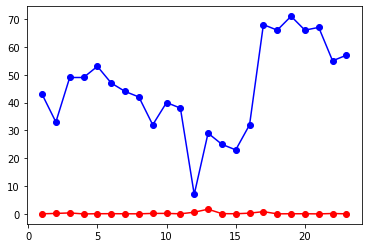

In [35]:
data_by_hour = words_time.select("word", "number", "month", "hour")
data_by_hour.show(5)

#Apply poisson method with hourly buckets
eta = poisson_method(data_by_hour, 'word', 0.95, 1)

### Exercise 5

In [18]:
hashtags = exp_words_f.filter( exp_words_f.word.startswith('#'))\
                      .withColumnRenamed('word', 'hashtag')

In [19]:
most_freq_hash = hashtags.groupBy('hashtag') \
    .count() \
    .sort('count', ascending=False) 
most_freq_hash.show(30)

+--------------------+-----+
|             hashtag|count|
+--------------------+-----+
|         #curecancer| 3987|
|       #iowacaucuses| 3253|
|#deshkiawaazshehnaaz| 2871|
|    #mainbhiasimkigf| 2782|
|      #meraadarshsid| 2685|
|       #iheartawards| 1753|
|                #bts| 1658|
|           #asimriaz| 1512|
|        #thebachelor| 1358|
|         #iowacaucus| 1274|
|                 #bb| 1251|
|     #sidharthshukla| 1245|
|           #treasure| 1232|
|        #coronavirus| 1197|
|           #iacaucus| 1197|
|           #biggboss| 1156|
|         #loveisland|  999|
|          #superbowl|  976|
|     #worldcancerday|  965|
|               #sotu|  894|
|     #rightchoicesid|  843|
|              #yikes|  776|
|     #happyjisungday|  710|
|               #iowa|  696|
|            #btsarmy|  686|
|         #nowplaying|  646|
|                #nct|  640|
|       #rashamidesai|  582|
|                #raw|  581|
|             #superm|  574|
+--------------------+-----+
only showing t

###### Converting Hashtag Data Frame to array:

In [20]:
mfht = most_freq_hash.filter('count >= 500').select('hashtag').rdd.map(lambda x: x[0]).collect()

###### Getting words related to Hashtag example:

In [21]:
event_words = exp_words_f.filter( f.col('text').contains('#iowacaucuses'))

event_words.groupBy('word') \
           .count() \
           .sort('count', ascending=False)\
           .rdd\
           .map(lambda x: x[0])\
           .collect()[:12]

['#iowacaucuses',
 'iowa',
 'bernie',
 'caucus',
 'vote',
 'won',
 'tonight',
 '#iowacaucus',
 'biden',
 'app',
 '@donaldjtrumpjr',
 'dnc']

#### Ex5 using pySpark:

In [87]:
## Ex.5: Get the most frequent words for each event:
ht_f = hashtags.select('filtered', 'hashtag')\
                         .filter(f.col('hashtag').isin(mfht))\
                         .withColumn('word', f.explode('filtered'))\
                         .filter(~col('word').startswith('#'))\
                         .select('hashtag', 'word')\
                         .groupBy('hashtag', 'word')\
                         .count()\
                         .sort(['hashtag', 'count'], ascending=False)\
                         .filter('count >= 100')

ht_f.show(10)
    

+-------+-----------+-----+
|hashtag|       word|count|
+-------+-----------+-----+
| #yikes|@nickiminaj|  465|
| #yikes|      likes|  348|
| #yikes|        amp|  336|
| #yikes|       play|  325|
| #yikes|       life|  313|
| #yikes|        tag|  313|
| #yikes|    yzdifvf|  310|
| #yikes|       rosa|  137|
| #yikes|      parks|  129|
| #yikes|      nicki|  121|
+-------+-----------+-----+
only showing top 10 rows



#### Showing the top 10 most frequent words by events:

In [ ]:
for ht in mfht:
    ht_f.filter(col('hashtag').isin(ht)).show(10)

+-----------+-----------+-----+
|    hashtag|       word|count|
+-----------+-----------+-----+
|#curecancer|trueworship| 3951|
|#curecancer|     cancer| 2441|
|#curecancer|       true| 1240|
|#curecancer|     rampal| 1073|
|#curecancer|    worship| 1042|
|#curecancer|      saint| 1040|
|#curecancer|       cure|  916|
|#curecancer|        god|  884|
|#curecancer|    maharaj|  859|
|#curecancer|   diseases|  846|
+-----------+-----------+-----+
only showing top 10 rows

+-------------+---------------+-----+
|      hashtag|           word|count|
+-------------+---------------+-----+
|#iowacaucuses|           iowa|  499|
|#iowacaucuses|         bernie|  346|
|#iowacaucuses|         caucus|  237|
|#iowacaucuses|           vote|  193|
|#iowacaucuses|            won|  173|
|#iowacaucuses|        tonight|  155|
|#iowacaucuses|          biden|  153|
|#iowacaucuses|            app|  151|
|#iowacaucuses|@donaldjtrumpjr|  150|
|#iowacaucuses|            dnc|  147|
+-------------+---------------+-

### Function that converts geolocalisation to place name:

In [25]:
def loc(coords):

    geolocator = Nominatim(user_agent="geoapiExercises")  
    if coords.shape != (2,):
        coords = coords.mean(axis = 0)
    
    Longitude = str(coords[0])
    Latitude = str(coords[1])
    
    location = geolocator.reverse(Latitude+","+Longitude)
    
    if(location == None):
        print("No location specified")
        return
 
    address = location.raw['address']

    # traverse the data
    city = address.get('city', '')
    state = address.get('state', '')
    country = address.get('country', '')
    code = address.get('country_code')
    zipcode = address.get('postcode')
    print('City : ', city)
    print('State : ', state)
    print('Country : ', country)
    print('Zip Code : ', zipcode)

### Exercise 6 and Exercice 7

In [27]:
for ht in mfht:
    event_words = exp_words_f.filter( f.col('text').contains(ht))
    event_texts = clean_texts.filter( f.col('text').contains(ht))

    ## Ex.5: Get the most frequent words for each event:
    most_freq_w = event_words.groupBy('word') \
                             .count() \
                             .sort('count', ascending=False)\
                             .rdd\
                             .map(lambda x: x[0])\
                             .collect()[:12]    
    
    # Ex.6 : Finding timeframe of the Event
    end   = event_texts.select(f.max(f.col('timestamp_ms'))).rdd.map(list).collect()[0][0]
    start = event_texts.select(f.min(f.col('timestamp_ms'))).rdd.map(list).collect()[0][0]
    
    # Ex.7 : Finding location of the Event
    coords = event_texts.na.drop(subset=["place"]) \
                        .select("place.bounding_box.coordinates") \
                        .rdd.map(list).collect()
    
    ## Gets the most common location from the tweets !
    location_name = event_texts_na.groupBy('place.name', 'place.country') \
                                  .count()\
                                  .sort('count', ascending=False)\
                                  .rdd\
                                  .map(lambda x : x[0] + ', ' + x[1])\
                                  .collect()
    

    if(coords != []):
        coords_mean = np.array(coords).squeeze().mean(axis = 0)
        loc(coords_mean)
    else: 
        print("No location specified")
    
    if(most_freq_w == []):
        most_freq_w = 'no words found...'
    
    if(location_name != []):
        location_name = location_name[0]
    else:
        location_name = 'No Location specified'
    

    end = str( pd.to_datetime(end, unit='ms').to_pydatetime())
    start = str(pd.to_datetime(start, unit='ms').to_pydatetime())
    print("Event : " + ht)
    print("Timeframe : from - " + start[:-7] + " to - " + end[:-7])
    print("Most frequent Location is : " + location_name)
    print("Most frequent words associated to the event: \n" + str(most_freq_w) + '\n\n')

City :  
State :  Madhya Pradesh
Country :  India
Zip Code :  476332
Event : #curecancer
Timeframe : from - 2020-02-04 03:16:13 to - 2020-02-04 22:42:39
Most frequent Location is : Mumbai, India
Most frequent words associated to the event: 
['#curecancer', 'trueworship', 'cancer', 'true', 'rampal', 'saint', 'worship', 'cure', 'god', 'maharaj', 'diseases', 'disease']


City :  
State :  West Virginia
Country :  United States
Zip Code :  None
Event : #iowacaucuses
Timeframe : from - 2020-02-03 23:00:11 to - 2020-02-04 22:58:28
Most frequent Location is : Mumbai, India
Most frequent words associated to the event: 
['#iowacaucuses', 'iowa', 'bernie', 'caucus', 'vote', 'won', 'tonight', '#iowacaucus', 'biden', 'app', '@donaldjtrumpjr', 'dnc']


City :  
State :  Maharashtra
Country :  India
Zip Code :  431201
Event : #deshkiawaazshehnaaz
Timeframe : from - 2020-02-04 01:58:49 to - 2020-02-04 22:59:12
Most frequent Location is : Mumbai, India
Most frequent words associated to the event: 
['#

In [25]:
# Method 1: Use describe()
t1 = time.time()
float(event_words.describe("timestamp_ms").filter("summary = 'max'").select("timestamp_ms").collect()[0].asDict()['timestamp_ms'])

t2 = time.time()
print("Method 1")
print("time spent computing: {:.4g}".format(t2-t1))

# Method 2: Use SQL
t1 = time.time()

event_words.registerTempTable("df_table")
spark.sql("SELECT MAX(timestamp_ms) as maxval FROM df_table").collect()[0].asDict()['maxval']

t2 = time.time()
print("Method 2")
print("time spent computing: {:.4g}".format(t2-t1))

# Method 3: Convert to RDD
t1 = time.time()

event_words.select("timestamp_ms").rdd.max()[0]

t2 = time.time()
print("Method 3")
print("time spent computing: {:.4g}".format(t2-t1))


# Method 4: select
t1 = time.time()

event_words.select(f.max(f.col('timestamp_ms')))

t2 = time.time()
print("Method 4")
print("time spent computing: {:.4g}".format(t2-t1))

Method 1
time spent computing: 6.778
Method 2
time spent computing: 6.634
Method 3
time spent computing: 6.558
Method 4
time spent computing: 0.009586


## Question 8:

Use NLP package from [nltk](https://www.nltk.org/api/nltk.sentiment.html).

In [54]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
#sid.polarity_scores(sentence)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /users/eleves-a/2018/jean-charles.layoun/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Sentiment analysis most frequent hashtags:

Following the **map reduce** paradigm to compute the sentiment associated with each event.

###### Map by hashtags:

In [55]:
sentiments_rdd = hashtags.select('filtered', 'hashtag')\
                         .filter(f.col('hashtag').isin(mfht))\
                         .rdd.map(lambda x: (x[1], sid.polarity_scores(' '.join(x[0]))))

## Because we want to reduce and aggregate with respect to each event(hashtag), we choose hashtag to be our key:
# sentiments_rdd has (key=hashtag, value=sentiment)
t1 = time.time()
sentiments_rdd.collect()
t2 = time.time()
time1 = t2-t1

In [56]:
sentiments_rdd.take(10)

[('#superbowl', {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 ('#btsarmy', {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 ('#coronavirus', {'neg': 0.0, 'neu': 0.66, 'pos': 0.34, 'compound': 0.5574}),
 ('#coronavirus', {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 ('#thebachelor', {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 ('#iowacaucuses', {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 ('#bts', {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 ('#nowplaying', {'neg': 0.0, 'neu': 0.811, 'pos': 0.189, 'compound': 0.2732}),
 ('#bts', {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 ('#giveaway', {'neg': 0.0, 'neu': 0.743, 'pos': 0.257, 'compound': 0.5859})]

###### Reduce on Hashtags:

In [57]:
def aggregate_sentiments(x, y):
    dict1 = x
    dict2 = y    
    
    for key in dict1.keys():
        dict1[key] += dict2[key]
        
    return dict1
    

aggreg = sentiments_rdd.reduceByKey(lambda x, y: aggregate_sentiments(x, y))

In [58]:

t1 = time.time()
event_sentiments_l = aggreg.collect()
t2 = time.time()
time2 = t2-t1

event_sentiments_l[:5]

[('#treasure',
  {'neg': 4.951999999999999,
   'neu': 1030.175000000003,
   'pos': 196.87100000000038,
   'compound': 349.67990000000117}),
 ('#arsd',
  {'neg': 35.58,
   'neu': 451.28099999999995,
   'pos': 50.13499999999999,
   'compound': 35.2231}),
 ('#iowa',
  {'neg': 73.184,
   'neu': 521.3799999999999,
   'pos': 101.45099999999998,
   'compound': 55.191799999999986}),
 ('#biggboss',
  {'neg': 61.392999999999994,
   'neu': 872.8369999999999,
   'pos': 221.77900000000002,
   'compound': 289.0983999999999}),
 ('#thebachelor',
  {'neg': 133.68300000000002,
   'neu': 1076.398,
   'pos': 147.925,
   'compound': 23.1815})]

In [59]:
def normalize_sentiment(x):
    dict1    = x
    sum_prob = dict1['neg'] + dict1['neu'] + dict1['pos']
    
    for key in dict1.keys():
        dict1[key] /= sum_prob
    return dict1


aggreg_normalized = aggreg.map(lambda x: (x[0], normalize_sentiment(x[1])))

In [60]:
t1 = time.time()
event_sentiments_ln = aggreg_normalized.collect()
t2 = time.time()
time3 = t2-t1

In [61]:
event_sentiments_ln[:8]

[('#treasure',
  {'neg': 0.0040194870446218145,
   'neu': 0.8361823639324092,
   'pos': 0.15979814902296907,
   'compound': 0.2838315484278386}),
 ('#arsd',
  {'neg': 0.06625747677822555,
   'neu': 0.8403805614939405,
   'pos': 0.0933619617278341,
   'compound': 0.06559285357805274}),
 ('#iowa',
  {'neg': 0.1051471591847877,
   'neu': 0.7490930511555067,
   'pos': 0.1457597896597056,
   'compound': 0.07929685423446334}),
 ('#biggboss',
  {'neg': 0.05310771801949638,
   'neu': 0.7550434295926761,
   'pos': 0.19184885238782745,
   'compound': 0.2500831740929352}),
 ('#thebachelor',
  {'neg': 0.09844065490137749,
   'neu': 0.792631254942909,
   'pos': 0.10892809015571361,
   'compound': 0.0170702485850578}),
 ('#asimriaz',
  {'neg': 0.06977859288060737,
   'neu': 0.7629025185663331,
   'pos': 0.16731888855305946,
   'compound': 0.15989261982882397}),
 ('#curecancer',
  {'neg': 0.2291470615972054,
   'neu': 0.5569524341721126,
   'pos': 0.213900504230682,
   'compound': -0.0994352485939529

In [62]:
print("time spent computing the sentiments, aggregating and normalizing: {:.4g}s".format(time1 + time2 + time3))

time spent computing the sentiments, aggregating and normalizing: 39.36s


#### Computing average sentiment on all tweets:

In [63]:
sentences_rdd  = words_f.select('filtered').rdd.map(lambda x: ' '.join(x[0]))

In [70]:
num_sentences = len(sentences)

In [64]:
t1 = time.time()
sentences = sentences_rdd.collect()
t2 = time.time()
time4 = t2-t1

In [71]:
t1 = time.time()
overall_sent = {'neg': 0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
for sentence in sentences:
    sentiment = sid.polarity_scores(sentence)    
    for key in overall_sent.keys():
        overall_sent[key] += sentiment[key]
        
    
for key in overall_sent.keys():
        overall_sent[key] /= num_sentences
overall_sent
t2 = time.time()
time5 = t2-t1

In [72]:
print("time spent computing the sentiments not using an rdd: {:.4g}s".format(time4 + time5))

time spent computing the sentiments not using an rdd: 82.31s


##### Conclusion:
We can clearly see that using an rdd and utilizing the map reduce scheme gives us faster performance! Also, the naive algorithm above doesn't even group by hashtags...

### Question 9

We cluster tweets with the k-mean method.

In [15]:
from pyspark.mllib.clustering import KMeans, KMeansModel

clean_word_tokens.select("words").show(5)

# Form the data
data_to_cluster = exp_words_f.select("filtered").collect()
print(data_to_cluster[0])

"""
# Build the model (cluster the data)
clusters = KMeans.train(data_to_cluster, 2, maxIterations=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = data_to_cluster.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
clusters.save(sc, "target/org/apache/spark/PythonKMeansExample/KMeansModel")
sameModel = KMeansModel.load(sc, "target/org/apache/spark/PythonKMeansExample/KMeansModel")
"""

+--------------------+
|               words|
+--------------------+
|[@theythemsbian, ...|
|[rt, @camillediol...|
|[rt, @tinyseokjin...|
|[rt, @ibesuckafre...|
|[rt, @mikebloombe...|
+--------------------+
only showing top 5 rows



Py4JJavaError: An error occurred while calling o179.collectToPython.
: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.next(SparkPlan.scala:373)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.next(SparkPlan.scala:369)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.foreach(SparkPlan.scala:369)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1(SparkPlan.scala:391)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1$adapted(SparkPlan.scala:390)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$3343/0x000000010091f840.apply(Unknown Source)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:390)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3519)
	at org.apache.spark.sql.Dataset$$Lambda$3291/0x0000000101010840.apply(Unknown Source)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.Dataset$$Lambda$2771/0x000000010123a440.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$2776/0x000000010123d440.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$2772/0x000000010123b040.apply(Unknown Source)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:772)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3516)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
